# Air Quality Predictions with Amazon SageMaker and Amazon EMR

This notebook demonstrates the ability to use Apache Spark on Amazon EMR to do data prep with two different datasets in order to build an urban air quality predictor with Amazon SageMaker.

To create the environment, use the `us-east-1` CloudFormation template from the [Create and Managed Amazon EMR Clusters from SageMaker Studio](https://aws.amazon.com/blogs/machine-learning/part-1-create-and-manage-amazon-emr-clusters-from-sagemaker-studio-to-run-interactive-spark-and-ml-workloads/) blog post. This notebook makes use of the approach demonstrated in the blog post about how to [Build a model to predict the impact of weather on urban air quality using Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/build-a-model-to-predict-the-impact-of-weather-on-urban-air-quality-using-amazon-sagemaker/) and combines data from these two open datasets:
- [OpenAQ physical air quality data](https://registry.opendata.aws/openaq/)
- [NOAA Global Surface Summary of Day](https://registry.opendata.aws/noaa-gsod/)


Next, we use the `sagemaker_studio_analytics_extension` to connect to our EMR cluster that we created using "Clusters" section under the "SageMaker resources" tab to the left.

## Part 0: Connecting to the EMR Cluster

In [2]:
%load_ext sagemaker_studio_analytics_extension.magics
%sm_analytics emr connect --cluster-id j-17PGAEZFHXT8W --auth-type None   

Successfully read emr cluster(j-17PGAEZFHXT8W) details
Initiating EMR connection..
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
12,application_1674172997216_0014,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.
{"namespace": "sagemaker-analytics", "cluster_id": "j-17PGAEZFHXT8W", "error_message": null, "success": true, "service": "emr", "operation": "connect"}


In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
12,application_1674172997216_0014,pyspark,idle,Link,Link,None,✔


## Part 1: Data Prep in Amazon EMR

In the cells below, we're going to perform the following operations:

- Use Spark on the EMR cluster to read our data from the OpenAQ S3 Bucket.
- Filter the available data to Boston and NO2 readings (indicative of air quality).
- Group the readings by day.
- Export the aggregate dataset to a local Pandas dataframe in the notebook.

In [4]:
%%pretty

df = spark.read.json("s3://openaq-fetches/realtime-gzipped/2022-01-05/1641409725.ndjson.gz")
df2 = spark.read.schema(df.schema).json("s3://openaq-fetches/realtime-gzipped/20*")

df2.show(2, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

attribution,averagingPeriod,city,coordinates,country,date,location,mobile,parameter,sourceName,sourceType,unit,value
"[{Central Pollution Control Board, http://www.cpcb.gov.in/CAAQM}]","{hours, 0.25}",Jorapokhar,null,IN,"{2017-05-25T17:15:00+05:30, 2017-05-25T11:45:00.000Z}",Tata Stadium - Jorapokhar - JSPCB,false,no2,CPCB,government,µg/m³,9.59
"[{Central Pollution Control Board, http://www.cpcb.gov.in/CAAQM}]","{hours, 0.25}",Delhi,"{28.6517, 77.1581}",IN,"{2017-05-25T17:15:00+05:30, 2017-05-25T11:45:00.000Z}",Shadipur,false,no2,CPCB,government,µg/m³,13.44


In [5]:

import pyspark.sql.functions as F

'''
Filtering Data ONLY for 
    City      : Boston
    Parameter : no2

Adding a new Column 'YEAR'    
'''
dfBos = df2.filter(F.lower((df2.city)) \
           .contains('boston')) \
           .filter(df2.parameter == "no2") \
           .withColumn("year", F.substring(df2.date.utc, 1, 4)) \
           .cache()

dfBos.show(5, truncate=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+--------------------+-------+--------------------+--------------------+------+---------+----------+----------+----+-----+----+
|         attribution|averagingPeriod|                city|         coordinates|country|                date|            location|mobile|parameter|sourceName|sourceType|unit|value|year|
+--------------------+---------------+--------------------+--------------------+-------+--------------------+--------------------+------+---------+----------+----------+----+-----+----+
|[{US EPA AirNow, ...|   {hours, 1.0}|Boston-Cambridge-...|{42.474701, -70.9...|     US|{2017-05-25T09:00...|                LYNN| false|      no2|    AirNow|government| ppm|0.002|2017|
|[{US EPA AirNow, ...|   {hours, 1.0}|Boston-Cambridge-...|{42.3489, -71.097...|     US|{2017-05-25T09:00...|      BOSTON-KENMORE| false|      no2|    AirNow|government| ppm|0.015|2017|
|[{US EPA AirNow, ...|   {hours, 1.0}|Boston-Cambridge-...|{42.329399,

In [6]:
'''
Aggregating the data day wise by taking the average of `no2` value across each day. 
Reducing the no. of data points from ~2.5M to ~ 2K 
'''

dfNoAvg = dfBos.withColumn("ymd", F.to_date(dfBos.date.utc)) \
               .groupBy("ymd") \
               .avg("value") \
               .withColumnRenamed("avg(value)", "no2_avg")

dfNoAvg.show(10, truncate=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+
|       ymd|             no2_avg|
+----------+--------------------+
|2020-11-17|0.007710526315789475|
|2021-01-10|0.007300000000000001|
|2021-01-29|0.003769230769230...|
|2021-02-06|0.011196428571428569|
|2020-10-20|0.011890510948905112|
|2021-02-02|0.005068627450980...|
|2020-12-31|0.006067226890756304|
|2021-01-01|0.009551136363636362|
|2021-03-24|0.012571428571428572|
|2020-12-19|             0.01975|
+----------+--------------------+
only showing top 10 rows

While this is running, you can click the Spark UI link mentioned above to debug your job while it's running. Some useful pages to check out:
- "Jobs" page shows you the current status of your job/task
- "Event Timeline" on the Jobs page shows Spark Executors starting up or shutting down
- The "Executors" tab shows you how many Executors are started, what the capacity is of each, and allows you to drill into logs

Lets now more this `dfNoAvg` Spark dataframe in the %%local Python context as a Pandas dataframe with the same name, `dfNoAvg`


In [8]:
%%spark -o dfNoAvg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### In the local Notebook

In [9]:
%%local 

type(dfNoAvg)

pandas.core.frame.DataFrame

#### In the EMR Spark Cluster

In [10]:
type(dfNoAvg)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

## Part 2: Bring Spark results into SageMaker Studio

With the `%%spark -o` command above, we took the `dfNoAvg` dataframe from Spark and made it available in the `%%local` Python context as a Pandas dataframe with the same name. Now we can use local libraries to explore the data as well.

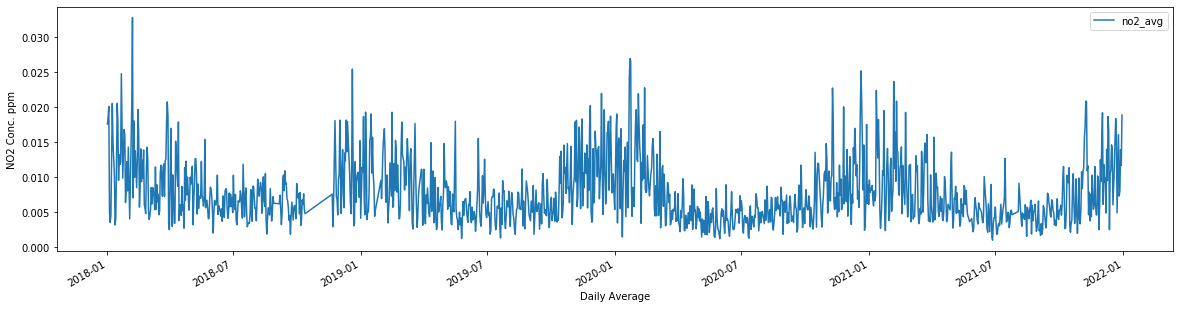

In [11]:
%matplotlib inline

import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]

df_sample_2018_2022 = dfNoAvg[(dfNoAvg['ymd'] > '2018-01-01') & (dfNoAvg['ymd'] < '2021-12-31')]
df_sample_2018_2022.plot(x='ymd')
plt.ylabel('NO2 Conc. ppm')
plt.xlabel('Daily Average')
plt.show()



In [12]:
%%local

# There are some gaps in 2017 and 2018 we need to fill
dfNoAvg = dfNoAvg.set_index('ymd')
dfNoAvg.loc['2018-10-11':'2018-11-21']['no2_avg'].head(50)

ymd
2018-10-13    0.004738
2018-10-12    0.005288
2018-10-11    0.007577
2018-11-21    0.007528
Name: no2_avg, dtype: float64

In [13]:
%%local

# Fill in the date index first
idx = pd.date_range(dfNoAvg.index.min(), dfNoAvg.index.max())
dfNoAvg = dfNoAvg.reindex(idx, fill_value=None)

dfNoAvg.loc['2018-10-11':'2018-11-20']['no2_avg'].head(10)

2018-10-11    0.007577
2018-10-12    0.005288
2018-10-13    0.004738
2018-10-14         NaN
2018-10-15         NaN
2018-10-16         NaN
2018-10-17         NaN
2018-10-18         NaN
2018-10-19         NaN
2018-10-20         NaN
Freq: D, Name: no2_avg, dtype: float64

In [14]:
%%local

# Then interpolate the values that are missing
dfNoAvg = dfNoAvg.interpolate(method='time')
dfNoAvg.loc['2018-10-11':'2018-10-20']['no2_avg'].head(10)

2018-10-11    0.007577
2018-10-12    0.005288
2018-10-13    0.004738
2018-10-14    0.004810
2018-10-15    0.004881
2018-10-16    0.004953
2018-10-17    0.005024
2018-10-18    0.005096
2018-10-19    0.005167
2018-10-20    0.005239
Freq: D, Name: no2_avg, dtype: float64

In [15]:
%%local

year_min, year_max = [f"{dfNoAvg.index.min().year}", f"{dfNoAvg.index.max().year}"]
year_min, year_max

('2016', '2023')

In [16]:
%%send_to_spark -i year_min

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'year_min' as 'year_min' to Spark kernel

In [17]:
%%send_to_spark -i year_max

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'year_max' as 'year_max' to Spark kernel

## Part 3: Data Prep in Amazon EMR with the second dataset

Now that our first dataset looks good, we used the `%%send_to_spark` magic above to send the start and stop years we want to read data for back to the Spark driver on EMR. We can use those variables to limit the data we want to read.

### And now the weather

In [19]:
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F

# Boston, MA, USA
longLeft, latBottom, longRight, latTop = [-71.191162,42.227087,-70.986022,42.397057]

dfSchema = spark.read.csv("s3://noaa-gsod-pds/2022/32509099999.csv", header=True, inferSchema=True)

# We read our first year, then union the rest of the years :)
def read_year(year):
    return spark.read.csv(f"s3://noaa-gsod-pds/{year}/", header=True, schema=dfSchema.schema)

year_range = range(int(year_min), int(year_max)+1)
df = read_year(year_range[0])
for year in year_range[1:]:
    df = df.union(read_year(year))

df = df \
        .withColumn('LATITUDE', df.LATITUDE.cast(DoubleType())) \
        .withColumn('LONGITUDE', df.LONGITUDE.cast(DoubleType()))

bostondf = df \
        .filter(df.LATITUDE >= latBottom) \
        .filter(df.LATITUDE <= latTop) \
        .filter(df.LONGITUDE >= longLeft) \
        .filter(df.LONGITUDE <= longRight)

# Rename columns so they're easier to read
bostonfeatures = bostondf.selectExpr("Date as date", "MAX as temp_max", "MIN as temp_min", "WDSP as wind_avg", "SLP as pressure_sea_level", "STP as pressure_station", "VISIB as visibility")

# Remove invalid readings
no_data_mappings = [
    ["temp_max", 9999.9],
    ["temp_min", 9999.9],
    ["wind_avg", 999.9],
    ["pressure_sea_level", 9999.9],
    ["pressure_station", 9999.9],
    ["visibility", 999.9],
]
for [name, val] in no_data_mappings:
    bostonfeatures = bostonfeatures \
                        .withColumn(name, F.when(F.col(name)==val, None) \
                                           .otherwise(F.col(name)))
    
# Now average each reading per day
bostonfeatures = bostonfeatures \
                    .groupBy("date") \
                    .agg(*[F.mean(c).alias(c) for c in bostonfeatures.columns[1:]])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
%%spark -o bostonfeatures

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Part 4: Data Analysis in SageMaker Studio

We again use the `%%spark -o` magic to send the aggregate back to SageMaker so we can do some exploration.

One thing to note is that you can certainly do some of this exploration with Spark as well. It just depends on the use case and the size of your data. Because we've aggregated our data down to a few thousand rows, it's relatively easy to manage in the notebook. But if you're unable to do this, you can still use Spark to split your training/test datasets or do other aggregations and write the results out to S3.

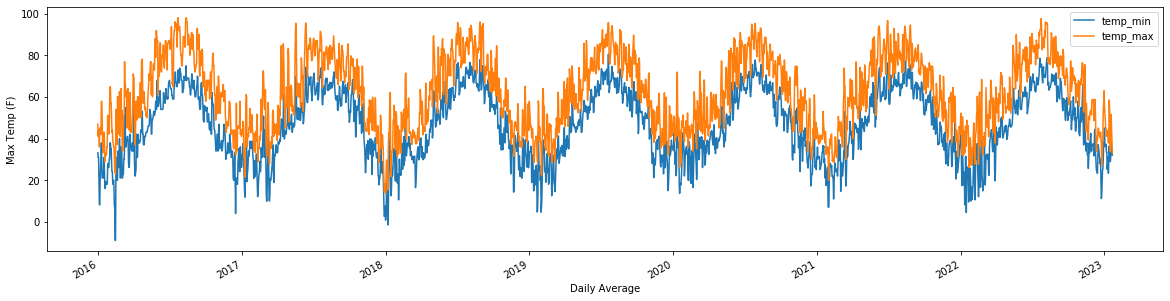

In [21]:
%%local

bostonfeatures.plot(x='date', y=['temp_min', 'temp_max'])
plt.ylabel('Max Temp (F)')
plt.xlabel('Daily Average')
plt.show()

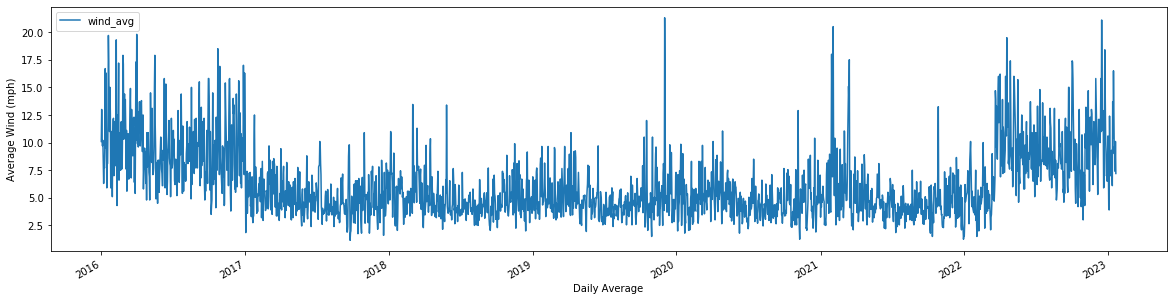

In [22]:
%%local

bostonfeatures.plot(x='date', y=['wind_avg'])
plt.ylabel('Average Wind (mph)')
plt.xlabel('Daily Average')
plt.show()

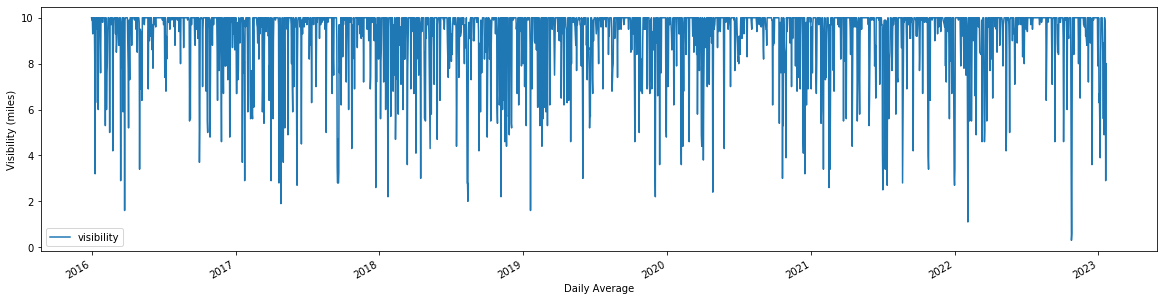

In [23]:
%%local

bostonfeatures.plot(x='date', y=['visibility'])
plt.ylabel('Visibility (miles)')
plt.xlabel('Daily Average')
plt.show()

## Part 5: Marry the data

Now that we've taken a quick look at our data and done some initial exploration, let's merge the two datasets.

In [24]:
%%local

# First Dataset - NO2 Dataset
print(dfNoAvg)

# Second Dataset - Weather Dataset 
bostonfeaturesi = bostonfeatures.set_index('date').sort_index()

print(bostonfeaturesi)

             no2_avg
2016-03-10  0.007571
2016-03-11  0.012281
2016-03-12  0.007848
2016-03-13  0.006382
2016-03-14  0.007338
...              ...
2023-01-20  0.009812
2023-01-21  0.007531
2023-01-22  0.004969
2023-01-23  0.008376
2023-01-24  0.008586

[2512 rows x 1 columns]
            temp_max  temp_min  ...  pressure_station  visibility
date                            ...                              
2016-01-01     46.90     33.10  ...             13.40        10.0
2016-01-02     41.00     30.90  ...             12.10         9.9
2016-01-03     44.10     30.90  ...              8.60        10.0
2016-01-04     44.10     19.90  ...             12.30         9.3
2016-01-05     36.00      8.10  ...             30.00        10.0
...              ...       ...  ...               ...         ...
2023-01-17     50.20     31.45  ...            501.30        10.0
2023-01-18     51.55     37.40  ...            500.95         9.9
2023-01-19     46.00     36.25  ...            506.25         9

In [25]:
%%local

# We need to make sure the data frames line up, so we'll create new
# dataframes from the min and max of the existing ones.

# Try Catch for Spark2 / Spark3 Compatability
try:
    min_viable_date = max(dfNoAvg.index.min(), bostonfeaturesi.index.min())
    max_viable_date = min(dfNoAvg.index.max(), bostonfeaturesi.index.max())
except:
    dfNoAvg = dfNoAvg.tz_localize(tz='UTC')
    min_viable_date = max(dfNoAvg.index.min(), bostonfeaturesi.index.min())
    max_viable_date = min(dfNoAvg.index.max(), bostonfeaturesi.index.max())
    
print(f"Merging dataframes between {min_viable_date} and {max_viable_date}")

comp_df = pd.merge(
    bostonfeaturesi[min_viable_date:max_viable_date],
    dfNoAvg[min_viable_date:max_viable_date][['no2_avg']],
    left_index=True, right_index=True
)
print(comp_df.sort_index().head(20))

Merging dataframes between 2016-03-10 00:00:00 and 2023-01-21 00:00:00
            temp_max  temp_min  ...  visibility   no2_avg
2016-03-10      66.0      55.0  ...         8.8  0.007571
2016-03-11      66.0      42.1  ...         8.8  0.012281
2016-03-12      60.1      36.0  ...        10.0  0.007848
2016-03-13      63.0      36.0  ...        10.0  0.006382
2016-03-14      63.0      39.0  ...        10.0  0.007338
2016-03-15      45.0      39.0  ...         2.9  0.008294
2016-03-16      48.0      41.0  ...         9.2  0.009250
2016-03-17      64.0      41.0  ...         7.8  0.009163
2016-03-18      64.0      39.0  ...         9.8  0.009076
2016-03-19      52.0      28.9  ...        10.0  0.008989
2016-03-20      45.0      26.1  ...        10.0  0.008902
2016-03-21      44.1      26.1  ...         5.9  0.008814
2016-03-22      48.9      33.1  ...        10.0  0.008727
2016-03-23      62.1      42.1  ...        10.0  0.010813
2016-03-24      43.0      37.0  ...         9.1  0.008273
2

In [26]:
%%local

# Check some data we looked into previously
print(comp_df.loc['2018-10-11':'2018-10-20'].sort_index())
comp_df = comp_df.sort_index()

            temp_max  temp_min  ...  visibility   no2_avg
2018-10-11     80.85     58.00  ...         5.5  0.007577
2018-10-12     67.55     56.85  ...         8.5  0.005288
2018-10-13     60.35     47.55  ...         9.5  0.004738
2018-10-14     57.90     44.80  ...        10.0  0.004810
2018-10-15     66.85     46.35  ...        10.0  0.004881
2018-10-16     69.10     46.05  ...        10.0  0.004953
2018-10-17     62.60     44.15  ...        10.0  0.005024
2018-10-18     57.40     39.00  ...         9.9  0.005096
2018-10-19     61.90     37.20  ...        10.0  0.005167
2018-10-20     63.85     54.65  ...        10.0  0.005239

[10 rows x 7 columns]


Now that we've merged them, we can do some quick correlation tests to see what the impact is of different weather events on NO2 readings.

Please see the [afore-mentioned blog post](https://aws.amazon.com/blogs/machine-learning/build-a-model-to-predict-the-impact-of-weather-on-urban-air-quality-using-amazon-sagemaker/) for more in-depth explations of these different charts.

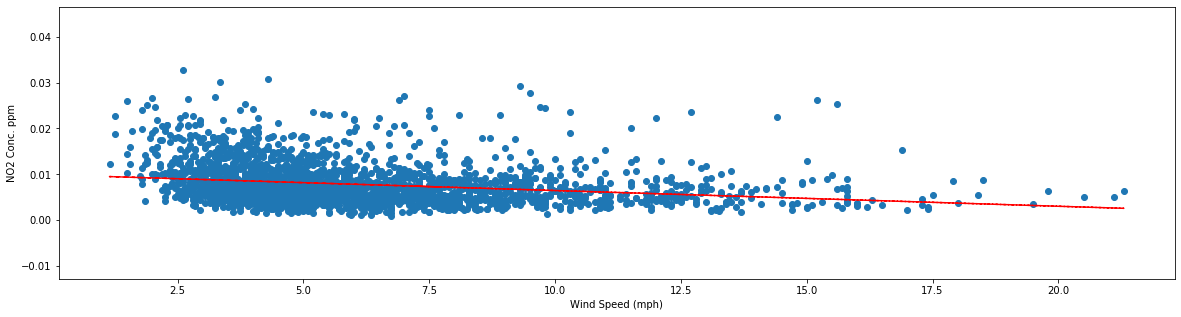

In [27]:
%%local

mydata = comp_df[['wind_avg','no2_avg']]

x = mydata['wind_avg']
y = mydata['no2_avg']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.ylabel('NO2 Conc. ppm')
plt.xlabel('Wind Speed (mph)')
plt.show()

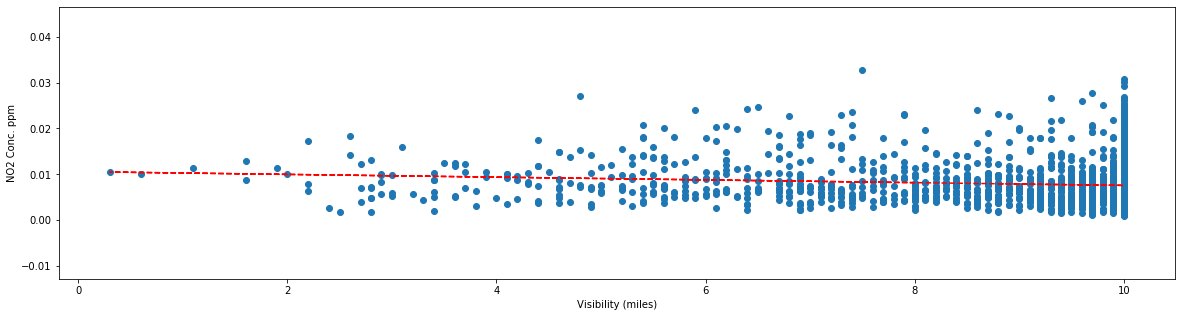

In [28]:
%%local

mydata = comp_df[['visibility','no2_avg']].dropna()

x = mydata['visibility']
y = mydata['no2_avg']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.ylabel('NO2 Conc. ppm')
plt.xlabel('Visibility (miles)')
plt.show()

plt.show()

In [29]:
%%local

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Drop the 1st row as NaN
aq_df = comp_df.iloc[1:].copy()

# Drop visibility as it didn't seem correlate much and has NaNs that break the training
aq_df = aq_df.drop('visibility', 1)

# Use the data from years 2016 up to 2020 as training, and the year 2021 as our candidate year for testing and validating our model.
aq_train_df = aq_df[aq_df.index.year < 2021]
aq_test_df = aq_df[aq_df.index.year == 2021]

x_train = aq_train_df.drop('no2_avg',axis=1)
x_test = aq_test_df.drop('no2_avg',axis=1)

y_train = aq_train_df[["no2_avg"]]
y_test = aq_test_df[["no2_avg"]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.head())

(1710, 5) (1710, 1)
(354, 5) (354, 1)
            temp_max  temp_min  wind_avg  pressure_sea_level  pressure_station
2016-03-11      66.0      42.1       6.7              1014.9              13.4
2016-03-12      60.1      36.0       8.6              1023.6              22.6
2016-03-13      63.0      36.0      10.3              1014.5              13.5
2016-03-14      63.0      39.0      12.7              1024.2              23.4
2016-03-15      45.0      39.0      14.9              1014.9              13.5


In [30]:
%%local

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# sMAPE is used in KDD Air Quality challenge: https://biendata.com/competition/kdd_2018/evaluation/ 
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

def print_metrics(y_test, y_pred):
    print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
    print('Variance score: %.4f' % r2_score(y_test, y_pred))
    print('Explained variance score: %.4f' % explained_variance_score(y_test, y_pred))
    forecast_err = np.array(y_test) - np.array(y_pred)
    print('Forecast bias: %.4f' % (np.sum(forecast_err) * 1.0/len(y_pred) ))
    print('sMAPE: %.4f' % smape(y_test, y_pred))

In [31]:
%%local

import boto3
from sagemaker import get_execution_role, session

sess = session.Session() 
bucket = sess.default_bucket()

# This is used to run the LinearLearner training job
role = get_execution_role()

## Part 6: Train and Deploy a Machine Learning Model

In the section below, we create a new training job using the Linear Learner algorithm. Once that job completes, we deploy an endpoint and run some validation tests against it.

💁

**NOTE**: You only need to create this training job and deploy it once. You can use the same endpoint, even in future runs of this notebook, without re-training or re-deploying.

💁

In [32]:
%%local

from sagemaker import LinearLearner

data_location = f's3://{bucket}/aq-linearlearner/data/train'
output_location = f's3://{bucket}/aq-linearlearner/output'

llearner = LinearLearner(role=role,
                predictor_type='regressor',
                normalize_data=True,
                normalize_label=True,
                instance_count=1,
                use_spot_instances = True,
                max_run= 1800,
                max_wait = 3600,
                instance_type='ml.c5.xlarge',
                output_path=output_location,
                data_location=data_location)

In [33]:
%%local

llearner.fit([
    llearner.record_set(x_train.values.astype('float32'), y_train.values[:, 0].astype('float32'), channel='train'),
    llearner.record_set(x_test.values.astype('float32'), y_test.values[:, 0].astype('float32'), channel='test')
])

2023-01-24 17:54:04 Starting - Starting the training job...
2023-01-24 17:54:29 Starting - Preparing the instances for trainingProfilerReport-1674582844: InProgress
.........
2023-01-24 17:55:49 Downloading - Downloading input data...
2023-01-24 17:56:29 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/24/2023 17:57:13 INFO 140289507411776] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_

### Create our estimator

In [34]:
%%local

llearner_predictor = llearner.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

---------------!

In [35]:
# %%local

# result = llearner_predictor.predict(x_test.values.astype('float32'))
# y_sm_pred = [r.label["score"].float32_tensor.values[0] for r in result]
# y_sm_test = y_test.values[:, 0].astype('float32')
# print_metrics(y_sm_test, y_sm_pred)

RMSE: 0.0033
Variance score: 0.3769
Explained variance score: 0.3770
Forecast bias: 0.0000
sMAPE: 0.3617


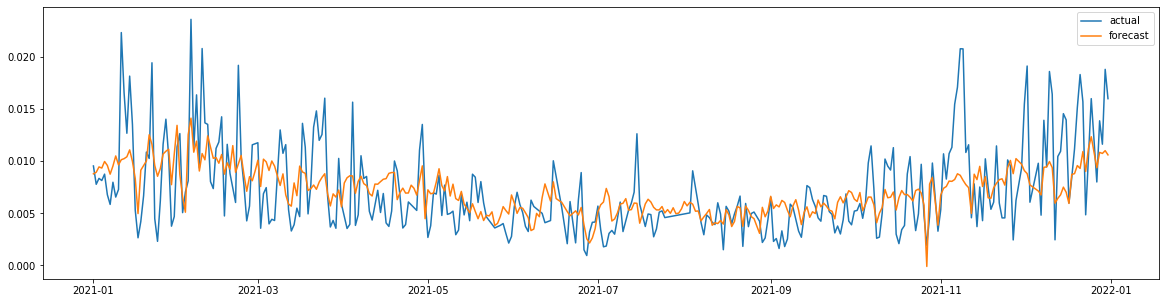

In [36]:
%%local

y_sm_pred_df = pd.DataFrame(y_sm_pred, columns=y_train.columns).set_index(y_test.index).sort_index()
y_sm_test_df = pd.DataFrame(y_sm_test, columns=y_train.columns).set_index(y_test.index).sort_index()

plt.plot(y_sm_test_df, label='actual')
plt.plot(y_sm_pred_df, label='forecast')
plt.legend()
plt.show()

In [44]:
%%local

endpoint_name = llearner_predictor.endpoint_name
print(endpoint_name)

linear-learner-2023-01-24-17-59-00-156


### Reuse an existing estimator

In [45]:
%%local

# The endpoint can take a while to create, so we'll use a previously created one.

# Can specify if there is an existing endpoint
# endpoint_name = ""

from sagemaker import LinearLearnerPredictor

llearner_predictor = LinearLearnerPredictor(endpoint_name)
result = llearner_predictor.predict(x_test.values.astype('float32'))
y_sm_pred = [r.label["score"].float32_tensor.values[0] for r in result]
y_sm_test = y_test.values[:, 0].astype('float32')

print_metrics(y_sm_test, y_sm_pred)

RMSE: 0.0033
Variance score: 0.3769
Explained variance score: 0.3770
Forecast bias: 0.0000
sMAPE: 0.3617


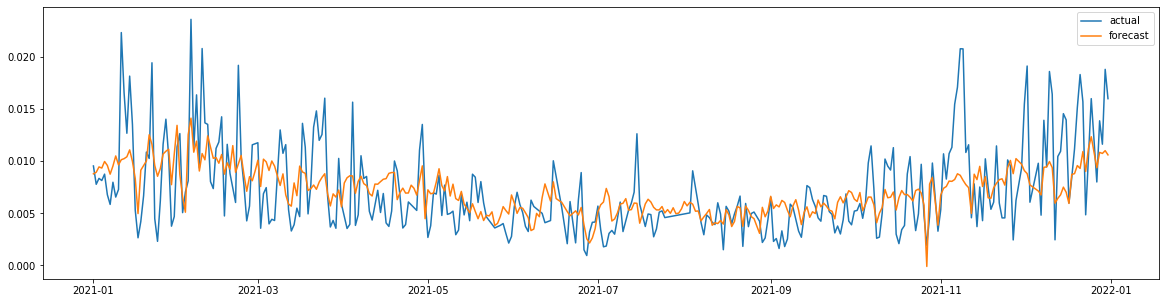

In [46]:
%%local

y_sm_pred_df = pd.DataFrame(y_sm_pred, columns=y_train.columns).set_index(y_test.index).sort_index()
y_sm_test_df = pd.DataFrame(y_sm_test, columns=y_train.columns).set_index(y_test.index).sort_index()

plt.plot(y_sm_test_df, label='actual')
plt.plot(y_sm_pred_df, label='forecast')
plt.legend()
plt.show()

## Clean Up

In [ ]:
%%cleanup -f

In [ ]:
%%local
llearner_predictor.delete_endpoint()